In [51]:
# 노드가 7개이고, 최대 이동 가능 거리가 100km 인 경우

from ortools.constraint_solver import pywrapcp, routing_enums_pb2

def create_data_model(distances):
    data = {}
    
    """데이터 모델을 생성합니다."""
    dist_matrix = distances.values.tolist()
    data['distance_matrix'] = dist_matrix
    data['num_vehicles'] = 100
    data['depot'] = 0

    return data

def main():
    """VRP 문제를 설정하고 해결합니다."""
    data = create_data_model()

    # 노드 수, 차량 수, 출발/도착 지점을 설정
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']), data['num_vehicles'], data['depot'])

    # 경로 모델 생성
    routing = pywrapcp.RoutingModel(manager)

    def distance_callback(from_index, to_index):
        """두 노드 간의 거리를 계산하는 콜백 함수"""
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]

    # 거리 콜백 함수 등록
    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # 비용 함수 설정
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # 거리 차원 생성
    dimension_name = 'Distance'
    routing.AddDimension(
        transit_callback_index,
        0,  # no slack
        200,  # 각 차량의 최대 이동 거리 (200km)
        True,  # start cumul to zero
        dimension_name)
    
    distance_dimension = routing.GetDimensionOrDie(dimension_name)
    distance_dimension.SetGlobalSpanCostCoefficient(100)

    # 탐색 매개변수 설정
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    # 다양한 첫 번째 솔루션 전략 시도
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
    search_parameters.local_search_metaheuristic = (
        routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)
    search_parameters.time_limit.seconds = 30
    search_parameters.solution_limit = 1000
    # 로그 출력을 비활성화
    search_parameters.log_search = False

    # 문제 해결
    solution = routing.SolveWithParameters(search_parameters)

    if solution:
        print_solution(manager, routing, solution, distance_dimension)
    else:
        print("No solution found!")

def print_solution(manager, routing, solution, distance_dimension):
    """해결책을 출력합니다."""
    print('Objective: {}'.format(solution.ObjectiveValue()))
    total_distance = 0
    for vehicle_id in range(routing.vehicles()):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        route_distance = 0
        while not routing.IsEnd(index):
            plan_output += ' {} ->'.format(manager.IndexToNode(index))
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(previous_index, index, vehicle_id)
        plan_output += ' {}\n'.format(manager.IndexToNode(index))
        plan_output += 'Distance of the route: {}km\n'.format(route_distance)
        print(plan_output)
        total_distance += route_distance
    print('Total distance of all routes: {}km'.format(total_distance))

if __name__ == '__main__':
    main()


Objective: 20301
Route for vehicle 0:
 0 -> 6 -> 0
Distance of the route: 200km

Route for vehicle 1:
 0 -> 4 -> 3 -> 5 -> 2 -> 1 -> 0
Distance of the route: 101km

Total distance of all routes: 301km


In [52]:
# 노드를 10개로 증가시킨 경우도 잘 돌아감.

from ortools.constraint_solver import pywrapcp, routing_enums_pb2

def create_data_model():
    """데이터 모델을 생성합니다."""
    data = {}
    # 노드 간 거리 행렬 (확장된 예시 데이터)
    data['distance_matrix'] = [
        [0, 29, 20, 21, 16, 31, 100, 12, 45, 50],
        [29, 0, 15, 29, 28, 40, 72, 35, 55, 60],
        [20, 15, 0, 15, 14, 25, 81, 22, 48, 53],
        [21, 29, 15, 0, 4, 12, 92, 24, 47, 55],
        [16, 28, 14, 4, 0, 16, 94, 18, 50, 60],
        [31, 40, 25, 12, 16, 0, 99, 29, 49, 63],
        [100, 72, 81, 92, 94, 99, 0, 65, 80, 90],
        [12, 35, 22, 24, 18, 29, 65, 0, 28, 32],
        [45, 55, 48, 47, 50, 49, 80, 28, 0, 22],
        [50, 60, 53, 55, 60, 63, 90, 32, 22, 0],
    ]
    # 가상 차량 수를 설정
    data['num_vehicles'] = 2
    # 출발/도착 지점 (원점)
    data['depot'] = 0
    return data

def main():
    """VRP 문제를 설정하고 해결합니다."""
    data = create_data_model()

    # 노드 수, 차량 수, 출발/도착 지점을 설정
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']), data['num_vehicles'], data['depot'])

    # 경로 모델 생성
    routing = pywrapcp.RoutingModel(manager)

    def distance_callback(from_index, to_index):
        """두 노드 간의 거리를 계산하는 콜백 함수"""
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]

    # 거리 콜백 함수 등록
    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # 비용 함수 설정
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # 거리 차원 생성
    dimension_name = 'Distance'
    routing.AddDimension(
        transit_callback_index,
        0,  # no slack
        200,  # 각 차량의 최대 이동 거리 (200km)
        True,  # start cumul to zero
        dimension_name)
    
    distance_dimension = routing.GetDimensionOrDie(dimension_name)
    distance_dimension.SetGlobalSpanCostCoefficient(100)

    # 탐색 매개변수 설정
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    # 다양한 첫 번째 솔루션 전략 시도
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
    search_parameters.local_search_metaheuristic = (
        routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)
    search_parameters.time_limit.seconds = 30
    search_parameters.solution_limit = 1000
    # 로그 출력을 비활성화
    search_parameters.log_search = False

    # 문제 해결
    solution = routing.SolveWithParameters(search_parameters)

    if solution:
        print_solution(manager, routing, solution, distance_dimension)
    else:
        print("No solution found!")

def print_solution(manager, routing, solution, distance_dimension):
    """해결책을 출력합니다."""
    print('Objective: {}'.format(solution.ObjectiveValue()))
    total_distance = 0
    for vehicle_id in range(routing.vehicles()):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        route_distance = 0
        while not routing.IsEnd(index):
            plan_output += ' {} ->'.format(manager.IndexToNode(index))
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(previous_index, index, vehicle_id)
        plan_output += ' {}\n'.format(manager.IndexToNode(index))
        plan_output += 'Distance of the route: {}km\n'.format(route_distance)
        print(plan_output)
        total_distance += route_distance
    print('Total distance of all routes: {}km'.format(total_distance))

if __name__ == '__main__':
    main()


Objective: 18149
Route for vehicle 0:
 0 -> 7 -> 6 -> 1 -> 0
Distance of the route: 178km

Route for vehicle 1:
 0 -> 9 -> 8 -> 5 -> 3 -> 4 -> 2 -> 0
Distance of the route: 171km

Total distance of all routes: 349km


Objective: 18149
Route for vehicle 0:
 0 -> 7 -> 6 -> 1 -> 0
Distance of the route: 178km

Route for vehicle 1:
 0 -> 9 -> 8 -> 5 -> 3 -> 4 -> 2 -> 0
Distance of the route: 171km

Total distance of all routes: 349km


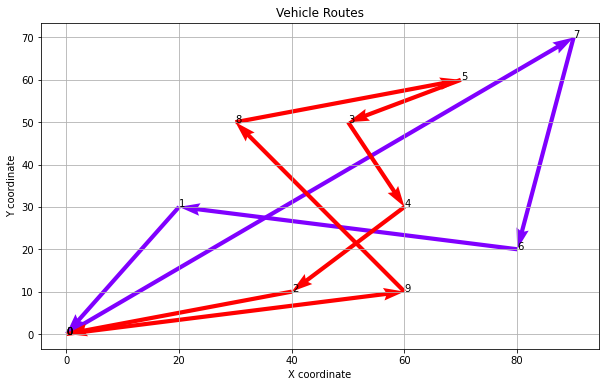

In [58]:
# 노드가 10개인 경우 시각화 추가

from ortools.constraint_solver import pywrapcp, routing_enums_pb2
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

def create_data_model():
    """데이터 모델을 생성합니다."""
    data = {}
    # 노드 간 거리 행렬 (확장된 예시 데이터)
    data['distance_matrix'] = [
        [0, 29, 20, 21, 16, 31, 100, 12, 45, 50],
        [29, 0, 15, 29, 28, 40, 72, 35, 55, 60],
        [20, 15, 0, 15, 14, 25, 81, 22, 48, 53],
        [21, 29, 15, 0, 4, 12, 92, 24, 47, 55],
        [16, 28, 14, 4, 0, 16, 94, 18, 50, 60],
        [31, 40, 25, 12, 16, 0, 99, 29, 49, 63],
        [100, 72, 81, 92, 94, 99, 0, 65, 80, 90],
        [12, 35, 22, 24, 18, 29, 65, 0, 28, 32],
        [45, 55, 48, 47, 50, 49, 80, 28, 0, 22],
        [50, 60, 53, 55, 60, 63, 90, 32, 22, 0],
    ]
    # 노드의 x, y 좌표
    data['locations'] = [
        (0, 0), (20, 30), (40, 10), (50, 50), (60, 30), 
        (70, 60), (80, 20), (90, 70), (30, 50), (60, 10)
    ]
    # 가상 차량 수를 설정
    data['num_vehicles'] = 2
    # 출발/도착 지점 (원점)
    data['depot'] = 0
    return data

def main():
    """VRP 문제를 설정하고 해결합니다."""
    data = create_data_model()

    # 노드 수, 차량 수, 출발/도착 지점을 설정
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']), data['num_vehicles'], data['depot'])

    # 경로 모델 생성
    routing = pywrapcp.RoutingModel(manager)

    def distance_callback(from_index, to_index):
        """두 노드 간의 거리를 계산하는 콜백 함수"""
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]

    # 거리 콜백 함수 등록
    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # 비용 함수 설정
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # 거리 차원 생성
    dimension_name = 'Distance'
    routing.AddDimension(
        transit_callback_index,
        0,  # no slack
        200,  # 각 차량의 최대 이동 거리 (200km)
        True,  # start cumul to zero
        dimension_name)
    
    distance_dimension = routing.GetDimensionOrDie(dimension_name)
    distance_dimension.SetGlobalSpanCostCoefficient(100)

    # 탐색 매개변수 설정
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    # 다양한 첫 번째 솔루션 전략 시도
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
    search_parameters.local_search_metaheuristic = (
        routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)
    search_parameters.time_limit.seconds = 30
    search_parameters.solution_limit = 1000
    # 로그 출력을 비활성화
    search_parameters.log_search = False

    # 문제 해결
    solution = routing.SolveWithParameters(search_parameters)

    if solution:
        print_solution(manager, routing, solution, distance_dimension, data)
    else:
        print("No solution found!")

def print_solution(manager, routing, solution, distance_dimension, data):
    """해결책을 출력하고 시각화합니다."""
    print('Objective: {}'.format(solution.ObjectiveValue()))
    total_distance = 0
    routes = []
    for vehicle_id in range(routing.vehicles()):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        route = []
        route_distance = 0
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route.append(node_index)
            plan_output += ' {} ->'.format(node_index)
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(previous_index, index, vehicle_id)
        node_index = manager.IndexToNode(index)
        route.append(node_index)
        plan_output += ' {}\n'.format(node_index)
        plan_output += 'Distance of the route: {}km\n'.format(route_distance)
        print(plan_output)
        routes.append(route)
        total_distance += route_distance
    print('Total distance of all routes: {}km'.format(total_distance))
    
    # 경로 시각화
    plot_routes(data['locations'], routes)

def plot_routes(locations, routes):
    """경로를 시각화합니다."""
    plt.figure(figsize=(10, 6))
    colors = cm.rainbow(np.linspace(0, 1, len(routes)))
    for route, color in zip(routes, colors):
        x_coords = [locations[node][0] for node in route]
        y_coords = [locations[node][1] for node in route]
        for i in range(len(route) - 1):
            plt.quiver(x_coords[i], y_coords[i], x_coords[i + 1] - x_coords[i], y_coords[i + 1] - y_coords[i],
                       angles='xy', scale_units='xy', scale=1, color=color)
        for i, node in enumerate(route):
            plt.text(locations[node][0], locations[node][1], str(node))
    plt.xlabel('X coordinate')
    plt.ylabel('Y coordinate')
    plt.title('Vehicle Routes')
    plt.grid()
    plt.show()

if __name__ == '__main__':
    main()

Objective: 19191
Route for vehicle 0:
 0 -> 1 -> 6 -> 7 -> 0
Distance of the route: 178km

Route for vehicle 1:
 0 -> 4 -> 3 -> 5 -> 8 -> 10 -> 9 -> 0
Distance of the route: 167km

Route for vehicle 2:
 0 -> 15 -> 21 -> 19 -> 20 -> 18 -> 25 -> 23 -> 22 -> 24 -> 12 -> 11 -> 0
Distance of the route: 180km

Route for vehicle 3:
 0 -> 26 -> 27 -> 29 -> 28 -> 0
Distance of the route: 183km

Route for vehicle 4:
 0 -> 2 -> 13 -> 16 -> 17 -> 14 -> 0
Distance of the route: 183km

Total distance of all routes: 891km


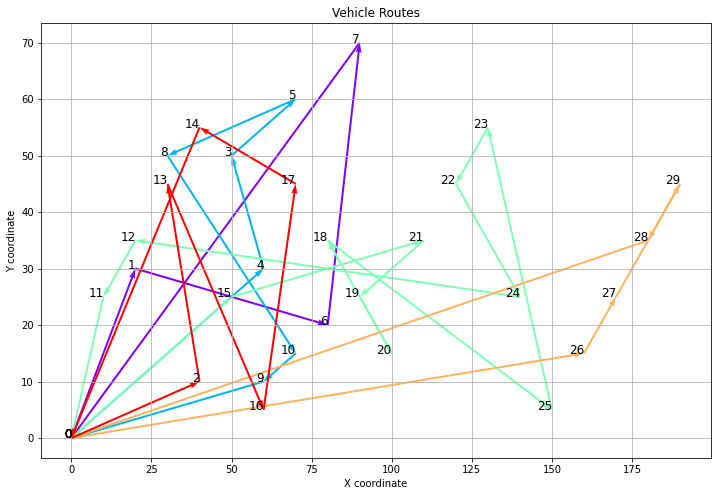

In [62]:
# 노드의 수가 30개인 경우, 시각화 추가

from ortools.constraint_solver import pywrapcp, routing_enums_pb2
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

def create_data_model():
    """데이터 모델을 생성합니다."""
    data = {}
    # 노드 간 거리 행렬 (확장된 예시 데이터)
    data['distance_matrix'] = [
        [0, 29, 20, 21, 16, 31, 100, 12, 45, 50, 55, 25, 30, 42, 34, 28, 67, 80, 52, 48, 50, 32, 76, 65, 58, 54, 38, 72, 85, 91],
        [29, 0, 15, 29, 28, 40, 72, 35, 55, 60, 66, 20, 22, 34, 44, 38, 74, 87, 55, 51, 52, 33, 77, 67, 61, 56, 39, 73, 86, 92],
        [20, 15, 0, 15, 14, 25, 81, 22, 48, 53, 59, 22, 23, 35, 37, 29, 68, 81, 51, 47, 48, 30, 74, 63, 57, 53, 35, 70, 83, 89],
        [21, 29, 15, 0, 4, 12, 92, 24, 47, 55, 63, 28, 30, 43, 50, 45, 78, 91, 60, 56, 58, 40, 83, 72, 66, 61, 42, 77, 90, 96],
        [16, 28, 14, 4, 0, 16, 94, 18, 50, 60, 65, 26, 27, 41, 45, 39, 75, 88, 56, 52, 54, 36, 79, 69, 63, 58, 40, 75, 88, 94],
        [31, 40, 25, 12, 16, 0, 99, 29, 49, 63, 70, 38, 40, 54, 55, 46, 82, 95, 63, 59, 61, 43, 86, 75, 69, 64, 45, 80, 93, 99],
        [100, 72, 81, 92, 94, 99, 0, 65, 80, 90, 95, 75, 77, 89, 91, 83, 116, 129, 97, 93, 95, 77, 120, 110, 104, 100, 82, 117, 130, 136],
        [12, 35, 22, 24, 18, 29, 65, 0, 28, 32, 38, 15, 16, 27, 28, 22, 59, 72, 42, 38, 39, 20, 64, 53, 47, 43, 25, 60, 73, 79],
        [45, 55, 48, 47, 50, 49, 80, 28, 0, 22, 26, 35, 36, 47, 48, 40, 75, 88, 56, 52, 54, 36, 79, 68, 62, 58, 40, 75, 88, 94],
        [50, 60, 53, 55, 60, 63, 90, 32, 22, 0, 10, 40, 41, 52, 53, 44, 80, 93, 61, 57, 59, 41, 84, 73, 67, 62, 43, 78, 91, 97],
        [55, 66, 59, 63, 65, 70, 95, 38, 26, 10, 0, 45, 46, 57, 58, 49, 85, 98, 66, 62, 64, 46, 89, 78, 72, 67, 48, 83, 96, 102],
        [25, 20, 22, 28, 26, 38, 75, 15, 35, 40, 45, 0, 5, 20, 22, 13, 50, 63, 31, 27, 29, 11, 54, 43, 37, 32, 13, 48, 61, 67],
        [30, 22, 23, 30, 27, 40, 77, 16, 36, 41, 46, 5, 0, 22, 23, 14, 51, 64, 32, 28, 30, 12, 55, 44, 38, 33, 14, 49, 62, 68],
        [42, 34, 35, 43, 41, 54, 89, 27, 47, 52, 57, 20, 22, 0, 10, 12, 38, 51, 25, 21, 23, 5, 48, 37, 31, 26, 7, 42, 55, 61],
        [34, 44, 37, 50, 45, 55, 91, 28, 48, 53, 58, 22, 23, 10, 0, 18, 30, 43, 19, 15, 17, 9, 40, 29, 23, 18, 11, 36, 49, 55],
        [28, 38, 29, 45, 39, 46, 83, 22, 40, 44, 49, 13, 14, 12, 18, 0, 48, 61, 29, 25, 27, 9, 52, 41, 35, 30, 11, 46, 59, 65],
        [67, 74, 68, 78, 75, 82, 116, 59, 75, 80, 85, 50, 51, 38, 30, 48, 0, 13, 29, 35, 37, 42, 40, 29, 23, 18, 41, 36, 49, 55],
        [80, 87, 81, 91, 88, 95, 129, 72, 88, 93, 98, 63, 64, 51, 43, 61, 13, 0, 42, 48, 50, 55, 53, 42, 36, 31, 54, 49, 62, 68],
        [52, 55, 51, 60, 56, 63, 97, 42, 56, 61, 66, 31, 32, 25, 19, 29, 29, 42, 0, 6, 8, 19, 33, 22, 16, 11, 34, 29, 42, 48],
        [48, 51, 47, 56, 52, 59, 93, 38, 52, 57, 62, 27, 28, 21, 15, 25, 35, 48, 6, 0, 2, 15, 31, 20, 14, 9, 32, 27, 40, 46],
        [50, 52, 48, 58, 54, 61, 95, 39, 54, 59, 64, 29, 30, 23, 17, 27, 37, 50, 8, 2, 0, 17, 33, 22, 16, 11, 34, 29, 42, 48],
        [32, 33, 30, 40, 36, 43, 77, 20, 36, 41, 46, 11, 12, 5, 9, 9, 42, 55, 19, 15, 17, 0, 43, 32, 26, 21, 8, 43, 56, 62],
        [76, 77, 74, 83, 79, 86, 120, 64, 79, 84, 89, 54, 55, 48, 40, 52, 40, 53, 33, 31, 33, 43, 0, 11, 17, 22, 45, 40, 53, 59],
        [65, 67, 63, 72, 69, 75, 110, 53, 68, 73, 78, 43, 44, 37, 29, 41, 29, 42, 22, 20, 22, 32, 11, 0, 6, 11, 34, 29, 42, 48],
        [58, 61, 57, 66, 63, 69, 104, 47, 62, 67, 72, 37, 38, 31, 23, 35, 23, 36, 16, 14, 16, 26, 17, 6, 0, 5, 28, 23, 36, 42],
        [54, 56, 53, 61, 58, 64, 100, 43, 58, 62, 67, 32, 33, 26, 18, 30, 18, 31, 11, 9, 11, 21, 22, 11, 5, 0, 26, 21, 34, 40],
        [38, 39, 35, 42, 40, 45, 82, 25, 40, 43, 48, 13, 14, 7, 11, 11, 41, 54, 34, 32, 34, 8, 45, 34, 28, 26, 0, 35, 48, 54],
        [72, 73, 70, 77, 75, 80, 117, 60, 75, 78, 83, 48, 49, 42, 36, 46, 36, 49, 29, 27, 29, 43, 40, 29, 23, 21, 35, 0, 13, 19],
        [85, 86, 83, 90, 88, 93, 130, 73, 88, 91, 96, 61, 62, 55, 49, 59, 49, 62, 42, 40, 42, 56, 53, 42, 36, 34, 48, 13, 0, 6],
        [91, 92, 89, 96, 94, 99, 136, 79, 94, 97, 102, 67, 68, 61, 55, 65, 55, 68, 48, 46, 48, 62, 59, 48, 42, 40, 54, 19, 6, 0]
    ]
    # 노드의 x, y 좌표
    data['locations'] = [
        (0, 0), (20, 30), (40, 10), (50, 50), (60, 30), 
        (70, 60), (80, 20), (90, 70), (30, 50), (60, 10),
        (70, 15), (10, 25), (20, 35), (30, 45), (40, 55),
        (50, 25), (60, 5), (70, 45), (80, 35), (90, 25),
        (100, 15), (110, 35), (120, 45), (130, 55), (140, 25),
        (150, 5), (160, 15), (170, 25), (180, 35), (190, 45)
    ]
    # 가상 차량 수를 설정
    data['num_vehicles'] = 5
    # 출발/도착 지점 (원점)
    data['depot'] = 0
    return data

def main():
    """VRP 문제를 설정하고 해결합니다."""
    data = create_data_model()

    # 노드 수, 차량 수, 출발/도착 지점을 설정
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']), data['num_vehicles'], data['depot'])

    # 경로 모델 생성
    routing = pywrapcp.RoutingModel(manager)

    def distance_callback(from_index, to_index):
        """두 노드 간의 거리를 계산하는 콜백 함수"""
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]

    # 거리 콜백 함수 등록
    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # 비용 함수 설정
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # 거리 차원 생성
    dimension_name = 'Distance'
    routing.AddDimension(
        transit_callback_index,
        0,  # no slack
        300,  # 각 차량의 최대 이동 거리 (200km)
        True,  # start cumul to zero
        dimension_name)
    
    distance_dimension = routing.GetDimensionOrDie(dimension_name)
    distance_dimension.SetGlobalSpanCostCoefficient(100)

    # 탐색 매개변수 설정
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    # 다양한 첫 번째 솔루션 전략 시도
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
    search_parameters.local_search_metaheuristic = (
        routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)
    search_parameters.time_limit.seconds = 30
    search_parameters.solution_limit = 1000
    # 로그 출력을 비활성화
    search_parameters.log_search = False

    # 문제 해결
    solution = routing.SolveWithParameters(search_parameters)

    if solution:
        print_solution(manager, routing, solution, distance_dimension, data)
    else:
        print("No solution found!")

def print_solution(manager, routing, solution, distance_dimension, data):
    """해결책을 출력하고 시각화합니다."""
    print('Objective: {}'.format(solution.ObjectiveValue()))
    total_distance = 0
    routes = []
    for vehicle_id in range(routing.vehicles()):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        route = []
        route_distance = 0
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route.append(node_index)
            plan_output += ' {} ->'.format(node_index)
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(previous_index, index, vehicle_id)
        node_index = manager.IndexToNode(index)
        route.append(node_index)
        plan_output += ' {}\n'.format(node_index)
        plan_output += 'Distance of the route: {}km\n'.format(route_distance)
        print(plan_output)
        routes.append(route)
        total_distance += route_distance
    print('Total distance of all routes: {}km'.format(total_distance))
    
    # 경로 시각화
    plot_routes(data['locations'], routes)

def plot_routes(locations, routes):
    """경로를 시각화합니다."""
    plt.figure(figsize=(12, 8))
    colors = cm.rainbow(np.linspace(0, 1, len(routes)))
    for route, color in zip(routes, colors):
        x_coords = [locations[node][0] for node in route]
        y_coords = [locations[node][1] for node in route]
        for i in range(len(route) - 1):
            plt.quiver(x_coords[i], y_coords[i], x_coords[i + 1] - x_coords[i], y_coords[i + 1] - y_coords[i],
                       angles='xy', scale_units='xy', scale=1, color=color, width=0.003)
        for i, node in enumerate(route):
            plt.text(locations[node][0], locations[node][1], str(node), fontsize=12, ha='right')
    plt.xlabel('X coordinate')
    plt.ylabel('Y coordinate')
    plt.title('Vehicle Routes')
    plt.grid()
    plt.show()

if __name__ == '__main__':
    main()


Objective: 19191
Route for vehicle 0:
 0 -> 1 -> 6 -> 7 -> 0
Distance of the route: 178km

Route for vehicle 1:
 0 -> 4 -> 3 -> 5 -> 8 -> 10 -> 9 -> 0
Distance of the route: 167km

Route for vehicle 2:
 0 -> 15 -> 21 -> 19 -> 20 -> 18 -> 25 -> 23 -> 22 -> 24 -> 12 -> 11 -> 0
Distance of the route: 180km

Route for vehicle 3:
 0 -> 26 -> 27 -> 29 -> 28 -> 0
Distance of the route: 183km

Route for vehicle 4:
 0 -> 2 -> 13 -> 16 -> 17 -> 14 -> 0
Distance of the route: 183km

Total distance of all routes: 891km


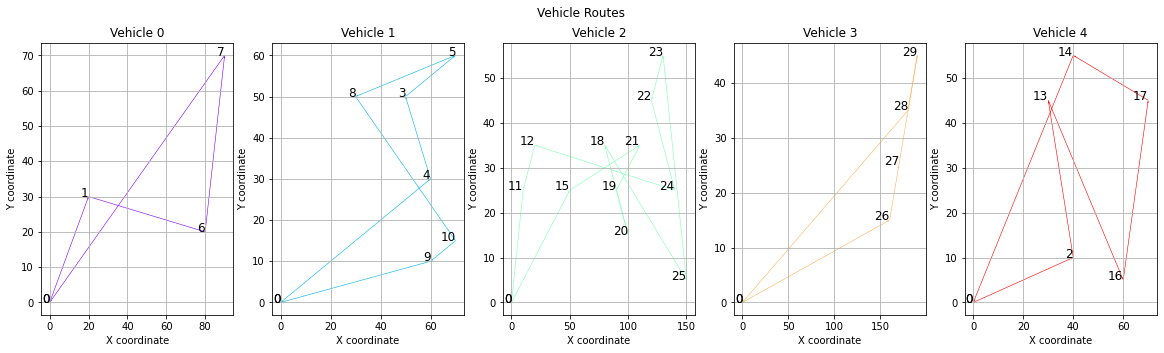

In [66]:
# 노드가 30개인 경우, 각각의 rounting을 별도로 분리해서 표시

from ortools.constraint_solver import pywrapcp, routing_enums_pb2
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

def create_data_model():
    """데이터 모델을 생성합니다."""
    data = {}
    # 노드 간 거리 행렬 (확장된 예시 데이터)
    data['distance_matrix'] = [
        [0, 29, 20, 21, 16, 31, 100, 12, 45, 50, 55, 25, 30, 42, 34, 28, 67, 80, 52, 48, 50, 32, 76, 65, 58, 54, 38, 72, 85, 91],
        [29, 0, 15, 29, 28, 40, 72, 35, 55, 60, 66, 20, 22, 34, 44, 38, 74, 87, 55, 51, 52, 33, 77, 67, 61, 56, 39, 73, 86, 92],
        [20, 15, 0, 15, 14, 25, 81, 22, 48, 53, 59, 22, 23, 35, 37, 29, 68, 81, 51, 47, 48, 30, 74, 63, 57, 53, 35, 70, 83, 89],
        [21, 29, 15, 0, 4, 12, 92, 24, 47, 55, 63, 28, 30, 43, 50, 45, 78, 91, 60, 56, 58, 40, 83, 72, 66, 61, 42, 77, 90, 96],
        [16, 28, 14, 4, 0, 16, 94, 18, 50, 60, 65, 26, 27, 41, 45, 39, 75, 88, 56, 52, 54, 36, 79, 69, 63, 58, 40, 75, 88, 94],
        [31, 40, 25, 12, 16, 0, 99, 29, 49, 63, 70, 38, 40, 54, 55, 46, 82, 95, 63, 59, 61, 43, 86, 75, 69, 64, 45, 80, 93, 99],
        [100, 72, 81, 92, 94, 99, 0, 65, 80, 90, 95, 75, 77, 89, 91, 83, 116, 129, 97, 93, 95, 77, 120, 110, 104, 100, 82, 117, 130, 136],
        [12, 35, 22, 24, 18, 29, 65, 0, 28, 32, 38, 15, 16, 27, 28, 22, 59, 72, 42, 38, 39, 20, 64, 53, 47, 43, 25, 60, 73, 79],
        [45, 55, 48, 47, 50, 49, 80, 28, 0, 22, 26, 35, 36, 47, 48, 40, 75, 88, 56, 52, 54, 36, 79, 68, 62, 58, 40, 75, 88, 94],
        [50, 60, 53, 55, 60, 63, 90, 32, 22, 0, 10, 40, 41, 52, 53, 44, 80, 93, 61, 57, 59, 41, 84, 73, 67, 62, 43, 78, 91, 97],
        [55, 66, 59, 63, 65, 70, 95, 38, 26, 10, 0, 45, 46, 57, 58, 49, 85, 98, 66, 62, 64, 46, 89, 78, 72, 67, 48, 83, 96, 102],
        [25, 20, 22, 28, 26, 38, 75, 15, 35, 40, 45, 0, 5, 20, 22, 13, 50, 63, 31, 27, 29, 11, 54, 43, 37, 32, 13, 48, 61, 67],
        [30, 22, 23, 30, 27, 40, 77, 16, 36, 41, 46, 5, 0, 22, 23, 14, 51, 64, 32, 28, 30, 12, 55, 44, 38, 33, 14, 49, 62, 68],
        [42, 34, 35, 43, 41, 54, 89, 27, 47, 52, 57, 20, 22, 0, 10, 12, 38, 51, 25, 21, 23, 5, 48, 37, 31, 26, 7, 42, 55, 61],
        [34, 44, 37, 50, 45, 55, 91, 28, 48, 53, 58, 22, 23, 10, 0, 18, 30, 43, 19, 15, 17, 9, 40, 29, 23, 18, 11, 36, 49, 55],
        [28, 38, 29, 45, 39, 46, 83, 22, 40, 44, 49, 13, 14, 12, 18, 0, 48, 61, 29, 25, 27, 9, 52, 41, 35, 30, 11, 46, 59, 65],
        [67, 74, 68, 78, 75, 82, 116, 59, 75, 80, 85, 50, 51, 38, 30, 48, 0, 13, 29, 35, 37, 42, 40, 29, 23, 18, 41, 36, 49, 55],
        [80, 87, 81, 91, 88, 95, 129, 72, 88, 93, 98, 63, 64, 51, 43, 61, 13, 0, 42, 48, 50, 55, 53, 42, 36, 31, 54, 49, 62, 68],
        [52, 55, 51, 60, 56, 63, 97, 42, 56, 61, 66, 31, 32, 25, 19, 29, 29, 42, 0, 6, 8, 19, 33, 22, 16, 11, 34, 29, 42, 48],
        [48, 51, 47, 56, 52, 59, 93, 38, 52, 57, 62, 27, 28, 21, 15, 25, 35, 48, 6, 0, 2, 15, 31, 20, 14, 9, 32, 27, 40, 46],
        [50, 52, 48, 58, 54, 61, 95, 39, 54, 59, 64, 29, 30, 23, 17, 27, 37, 50, 8, 2, 0, 17, 33, 22, 16, 11, 34, 29, 42, 48],
        [32, 33, 30, 40, 36, 43, 77, 20, 36, 41, 46, 11, 12, 5, 9, 9, 42, 55, 19, 15, 17, 0, 43, 32, 26, 21, 8, 43, 56, 62],
        [76, 77, 74, 83, 79, 86, 120, 64, 79, 84, 89, 54, 55, 48, 40, 52, 40, 53, 33, 31, 33, 43, 0, 11, 17, 22, 45, 40, 53, 59],
        [65, 67, 63, 72, 69, 75, 110, 53, 68, 73, 78, 43, 44, 37, 29, 41, 29, 42, 22, 20, 22, 32, 11, 0, 6, 11, 34, 29, 42, 48],
        [58, 61, 57, 66, 63, 69, 104, 47, 62, 67, 72, 37, 38, 31, 23, 35, 23, 36, 16, 14, 16, 26, 17, 6, 0, 5, 28, 23, 36, 42],
        [54, 56, 53, 61, 58, 64, 100, 43, 58, 62, 67, 32, 33, 26, 18, 30, 18, 31, 11, 9, 11, 21, 22, 11, 5, 0, 26, 21, 34, 40],
        [38, 39, 35, 42, 40, 45, 82, 25, 40, 43, 48, 13, 14, 7, 11, 11, 41, 54, 34, 32, 34, 8, 45, 34, 28, 26, 0, 35, 48, 54],
        [72, 73, 70, 77, 75, 80, 117, 60, 75, 78, 83, 48, 49, 42, 36, 46, 36, 49, 29, 27, 29, 43, 40, 29, 23, 21, 35, 0, 13, 19],
        [85, 86, 83, 90, 88, 93, 130, 73, 88, 91, 96, 61, 62, 55, 49, 59, 49, 62, 42, 40, 42, 56, 53, 42, 36, 34, 48, 13, 0, 6],
        [91, 92, 89, 96, 94, 99, 136, 79, 94, 97, 102, 67, 68, 61, 55, 65, 55, 68, 48, 46, 48, 62, 59, 48, 42, 40, 54, 19, 6, 0]
    ]
    # 노드의 x, y 좌표
    data['locations'] = [
        (0, 0), (20, 30), (40, 10), (50, 50), (60, 30), 
        (70, 60), (80, 20), (90, 70), (30, 50), (60, 10),
        (70, 15), (10, 25), (20, 35), (30, 45), (40, 55),
        (50, 25), (60, 5), (70, 45), (80, 35), (90, 25),
        (100, 15), (110, 35), (120, 45), (130, 55), (140, 25),
        (150, 5), (160, 15), (170, 25), (180, 35), (190, 45)
    ]
    # 가상 차량 수를 설정
    data['num_vehicles'] = 5
    # 출발/도착 지점 (원점)
    data['depot'] = 0
    return data

def main():
    """VRP 문제를 설정하고 해결합니다."""
    data = create_data_model()

    # 노드 수, 차량 수, 출발/도착 지점을 설정
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']), data['num_vehicles'], data['depot'])

    # 경로 모델 생성
    routing = pywrapcp.RoutingModel(manager)

    def distance_callback(from_index, to_index):
        """두 노드 간의 거리를 계산하는 콜백 함수"""
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]

    # 거리 콜백 함수 등록
    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # 비용 함수 설정
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # 거리 차원 생성
    dimension_name = 'Distance'
    routing.AddDimension(
        transit_callback_index,
        0,  # no slack
        300,  # 각 차량의 최대 이동 거리 (200km)
        True,  # start cumul to zero
        dimension_name)
    
    distance_dimension = routing.GetDimensionOrDie(dimension_name)
    distance_dimension.SetGlobalSpanCostCoefficient(100)

    # 탐색 매개변수 설정
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    # 다양한 첫 번째 솔루션 전략 시도
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
    search_parameters.local_search_metaheuristic = (
        routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)
    search_parameters.time_limit.seconds = 30
    search_parameters.solution_limit = 1000
    # 로그 출력을 비활성화
    search_parameters.log_search = False

    # 문제 해결
    solution = routing.SolveWithParameters(search_parameters)

    if solution:
        print_solution(manager, routing, solution, distance_dimension, data)
    else:
        print("No solution found!")

def print_solution(manager, routing, solution, distance_dimension, data):
    """해결책을 출력하고 시각화합니다."""
    print('Objective: {}'.format(solution.ObjectiveValue()))
    total_distance = 0
    routes = []
    for vehicle_id in range(routing.vehicles()):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        route = []
        route_distance = 0
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route.append(node_index)
            plan_output += ' {} ->'.format(node_index)
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(previous_index, index, vehicle_id)
        node_index = manager.IndexToNode(index)
        route.append(node_index)
        plan_output += ' {}\n'.format(node_index)
        plan_output += 'Distance of the route: {}km\n'.format(route_distance)
        print(plan_output)
        routes.append(route)
        total_distance += route_distance
    print('Total distance of all routes: {}km'.format(total_distance))
    
    # 경로 시각화
    plot_routes(data['locations'], routes)
    
    
def plot_routes(locations, routes):
    """경로를 시각화합니다."""
    num_routes = len(routes)
    fig, axes = plt.subplots(1, num_routes, figsize=(20, 5))
    colors = cm.rainbow(np.linspace(0, 1, num_routes))

    for ax, route, color in zip(axes, routes, colors):
        x_coords = [locations[node][0] for node in route]
        y_coords = [locations[node][1] for node in route]
        for i in range(len(route) - 1):
            ax.quiver(x_coords[i], y_coords[i], x_coords[i + 1] - x_coords[i], y_coords[i + 1] - y_coords[i],
                      angles='xy', scale_units='xy', scale=1, color=color, width=0.003)
        for i, node in enumerate(route):
            ax.text(locations[node][0], locations[node][1], str(node), fontsize=12, ha='right')
        ax.set_xlabel('X coordinate')
        ax.set_ylabel('Y coordinate')
        ax.set_title(f'Vehicle {routes.index(route)}')
        ax.grid()

    plt.suptitle('Vehicle Routes')
    plt.show()

if __name__ == '__main__':
    main()
